In [1]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('zone_data_1A_clustered.csv', nrows=40000)
zone_data_7 = pd.read_csv('zone_data_7_clustered.csv')
zone_data_6 = pd.read_csv('zone_data_6_clustered.csv')

# Separate zone_data_1A into two different DataFrames based on the cluster assignment
zone_data_1A_top = zone_data_1A[zone_data_1A['Cluster'] == 0]
zone_data_1A_bottom = zone_data_1A[zone_data_1A['Cluster'] == 1]

zone_data_7_top = zone_data_7[zone_data_7['Cluster'] == 0]
zone_data_7 = zone_data_7[zone_data_7['Cluster'] == 1]

zone_data_6_top = zone_data_6[zone_data_6['Cluster'] == 1]
zone_data_6 = zone_data_6[zone_data_6['Cluster'] == 0]

# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A_top.copy()
zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6_top.copy()
zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7_top.copy()
zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

print(zone_data_1A_top_sorted)




/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


         Status Application Creation Date Approved / Refused Date  \
15192   Refused                2008-04-28              30/04/2010   
9636    Expired                2009-01-06              26/08/2009   
10589  Recorded                2009-01-10              16/10/2009   
11781  Recorded                2009-01-10              05/10/2009   
2043   Recorded                2009-01-10              09/10/2009   
...         ...                       ...                     ...   
10747  Recorded                2024-12-02              22/02/2024   
8195   Recorded                2024-12-03              16/04/2024   
16325  Recorded                2024-12-03              04/04/2024   
544    Recorded                2024-12-03              21/03/2024   
6287   Recorded                2024-12-04              16/04/2024   

      Recorded / Rejected Date Water Share ID Water System Source Reliability  \
15192               30/04/2010      WEE****03            Goulburn        High   
9636     

## Function Dec

In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer

def process_and_combine_data(file_path, merge_data=None, merge_on=('Create_date_ordinal', 'Time_ordinal'), row_thresh_multiplier=0.5):
    # Load the data
    tempData = pd.read_csv(file_path, parse_dates=['Time'], index_col='Time')
    print("Array size:", tempData.shape)
    # Drop rows where more than half the columns have missing values
    row_thresh = len(tempData.columns) * row_thresh_multiplier
    tempData = tempData.dropna(axis=0, thresh=row_thresh)
    print("Array size:", tempData.shape)
    # Drop any columns with missing values
    tempData = tempData.dropna(axis=1, how='any')
    print("Array size:", tempData.shape)

    # Group data by 'Time', calculate the mean, and reset the index
    daily_tempData = tempData.groupby(tempData.index).mean().reset_index()
    daily_tempData['Time_ordinal'] = pd.to_datetime(daily_tempData['Time']).apply(lambda x: x.toordinal())

    return daily_tempData
    # If merge data is provided, merge it on the specified columns
    if merge_data is not None and merge_on:
        combined_data = pd.merge(merge_data, daily_tempData, left_on=merge_on[0], right_on=merge_on[1], how='inner')
        # Export the combined data to a CSV file
        combined_data.to_csv('combined_data.csv', index=False)
        return combined_data



# Water Temp

Array size: (10227, 402)
Array size: (4281, 402)
Array size: (4281, 7)
['226227', '235211', '409002', '409014', '409023', '409036', '409061']
Explained Variance Ratio: [0.8716016  0.10198781]


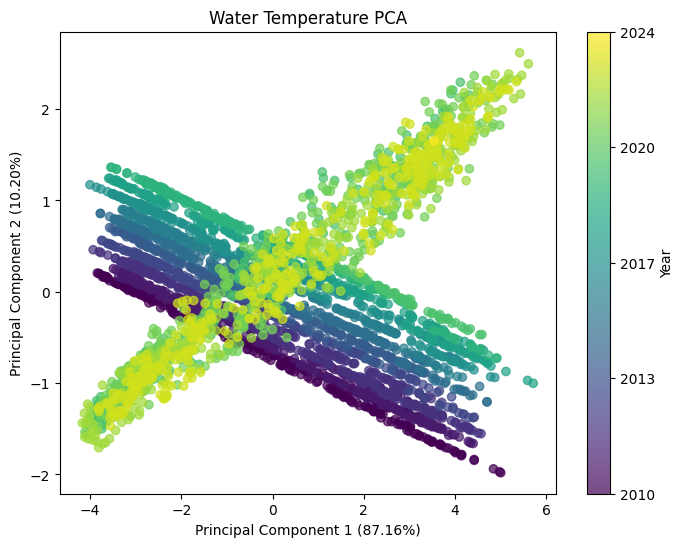

Explained Variance Ratio: [0.8716016  0.10198781]
      principal component 1  principal component 2
0                  4.418263              -1.836298
1                  4.011774              -1.751523
2                  3.304455              -1.589807
3                  3.157669              -1.554838
4                  3.403523              -1.619428
...                     ...                    ...
4276               3.731673               1.785217
4277               3.549289               1.482924
4278               3.297425               1.388059
4279               3.171738               1.381866
4280               3.537980               1.650768

[4281 rows x 2 columns]


In [3]:


# Example usage:
Water_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanTempData.csv'
combined_data = process_and_combine_data(Water_temp_file_path, merge_data=zone_data_1A_top_sorted)

# Export the combined data to a CSV file
combined_data.to_csv('combined_data.csv', index=False)


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Water Temperature PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# Trade off between spacial and temporal patterns

Temporal Trends: If the focus is on understanding how patterns evolve over time or capturing seasonal variations and long-term trends, having a longer time period with data from fewer stations might be more beneficial.
Spatial Patterns: If the goal is to compare spatial variations or the behavior across different locations, then analyzing more stations over a shorter period might provide more insights into spatial differences.

# Turbidity

Array size: (5114, 118)
Array size: (303, 118)
Array size: (303, 29)
['221224', '222201', '224217', '225209', '226017', '226027', '226227', '232204', '232210', '233217', '234201', '237205', '238206', '401549', '403241', '404216', '405240', '405257', '41001701', '41001702', '410134', '410729', '410733', '410747', '410761', '410774', '410777', '410781', '415608']
Explained Variance Ratio: [0.17750039 0.10966792]


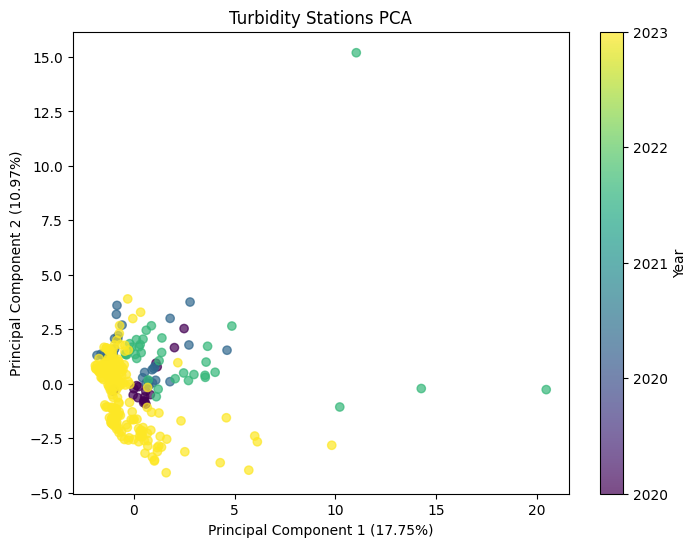

Explained Variance Ratio: [0.17750039 0.10966792]
     principal component 1  principal component 2
0                 2.491620               2.531892
1                 0.817918              -0.501575
2                 0.534924              -0.605824
3                 0.193564              -0.640169
4                -0.036180              -0.520052
..                     ...                    ...
298              -0.219175              -0.860208
299              -0.604515               0.377486
300              -0.573003               0.753316
301              -0.621394               0.539740
302              -0.876263               0.084871

[303 rows x 2 columns]


In [4]:
# Example usage:
Turbidity_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanTurbidity.csv'
combined_data = process_and_combine_data(Turbidity_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.56)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Turbidity Stations PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# Dry Air

Array size: (7007, 14)
Array size: (811, 14)
Array size: (811, 6)
['219027', '410102', '570818', '570825', '570947', 'ST514A']
Explained Variance Ratio: [0.5906079  0.16183106]


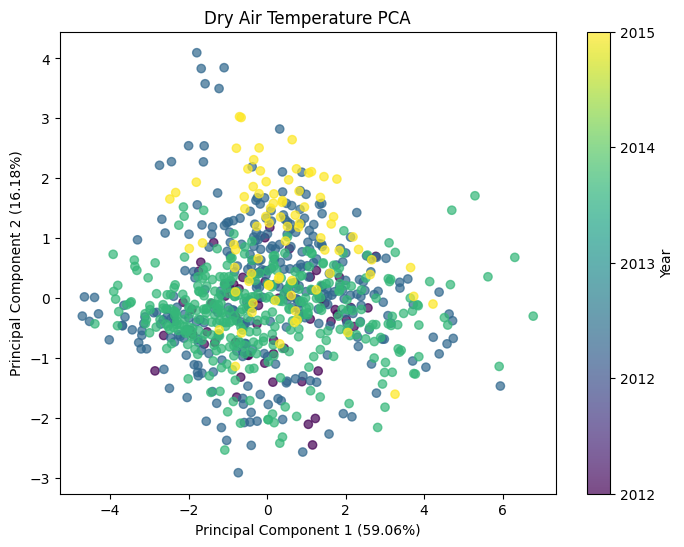

Explained Variance Ratio: [0.5906079  0.16183106]
     principal component 1  principal component 2
0                -0.674008              -1.321824
1                -1.897150              -0.605922
2                -1.414558              -0.090656
3                -0.258994              -0.435740
4                -1.531401              -0.565194
..                     ...                    ...
806               0.040699               0.209719
807              -0.361388              -0.085464
808              -0.805595               0.100563
809               0.208339              -0.042538
810              -1.220788              -0.532726

[811 rows x 2 columns]


In [5]:
# Example usage:
DryAir_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanDryAir.csv'
combined_data = process_and_combine_data(DryAir_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.6)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Dry Air Temperature PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# EC

Array size: (10227, 311)
Array size: (3465, 311)
Array size: (3465, 7)
['234200', '409002', '409023', '409061', '409062', '409086', '410781']
Explained Variance Ratio: [0.27960983 0.18903968]


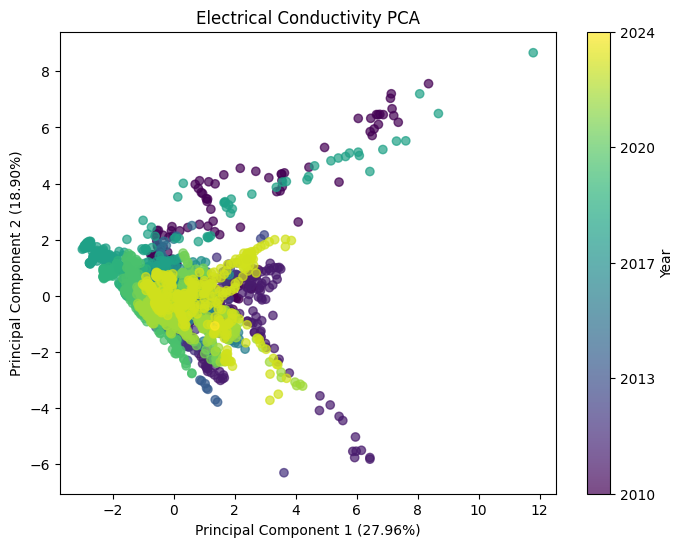

Explained Variance Ratio: [0.27960983 0.18903968]
      principal component 1  principal component 2
0                  0.015217               0.580642
1                  0.010098               0.533567
2                 -0.074553               0.519199
3                  0.092221               0.614241
4                  0.124712               0.298535
...                     ...                    ...
3460               2.362396              -1.672433
3461               3.156093              -2.787217
3462               3.426873              -3.503919
3463               3.151723              -3.719937
3464               1.343088              -1.070942

[3465 rows x 2 columns]


In [6]:
# Example usage:
EC_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyEC.csv'
combined_data = process_and_combine_data(EC_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.6)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Electrical Conductivity PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# RainFall

Array size: (14001, 725)
Array size: (5114, 725)
Array size: (5114, 27)
['00009', '215014', '225201', '225218', '226216', '226415', '231211', '233803', '234201', '237207', '403805', '410535', '570801', '570813', '570967', '570991', 'sp-o10109', 'sp-o10138', 'sp-o10350', 'sp-o10438', 'sp-o10606', 'sp-o10814', 'sp-o10926', 'sp-o10930', 'sp-o11430', 'sp-o11454', 'sp-o11590']
Explained Variance Ratio: [0.34056559 0.1155597 ]


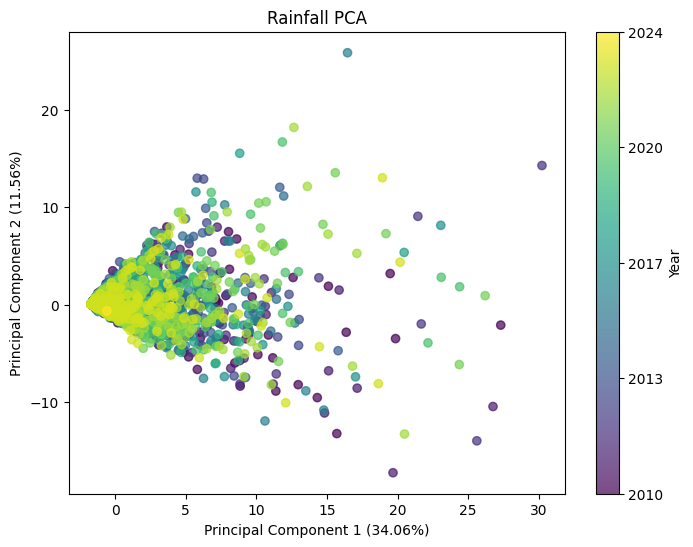

Explained Variance Ratio: [0.34056559 0.1155597 ]
      principal component 1  principal component 2
0                  8.479730              -5.982020
1                  2.741073              -0.445068
2                 -1.653418               0.171351
3                 -1.659946               0.138775
4                 -1.523726               0.379897
...                     ...                    ...
5109              -0.931549              -0.413808
5110              -1.013617              -0.391166
5111              -0.887163              -0.430232
5112              -0.667771              -0.486705
5113              -0.576228              -0.627859

[5114 rows x 2 columns]


In [7]:
# Example usage:
Rainfall_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyRainfall.csv'
combined_data = process_and_combine_data(Rainfall_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Rainfall PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# WaterCourse

Array size: (14000, 1360)
Array size: (5114, 1360)
Array size: (5114, 216)
['2122711', '215002', '215007', '215014', '215208', '215239', '217006', '218001', '218005', '218007', '219003', '219017', '219022', '219025', '219032', '220003', '220004', '221201', '221208', '221209', '221210', '221212', '221224', '222007', '222008', '222017', '222019', '222200', '222202', '222206', '222219', '222522', '222541', '223202', '223204', '223205', '223214', '224201', '224203', '224217', '225201', '225209', '225212', '225218', '225219', '225231', '225232', '226007', '226023', '226209', '226224', '226228', '226402', '227202', '227211', '227213', '227219', '227226', '227237', '228203C', '228204C', '228209B', '228212A', '228217C', '228225A', '228228A', '228229B', '228231A', '228235A', '228351B', '228356B', '228357A', '228362A', '228368A', '228380A', '228382A', '228393A', '229109A', '229135A', '229144A', '229149A', '229200B', '229206A', '229212A', '229249A', '229257A', '229270A', '229272A', '229403A', '22

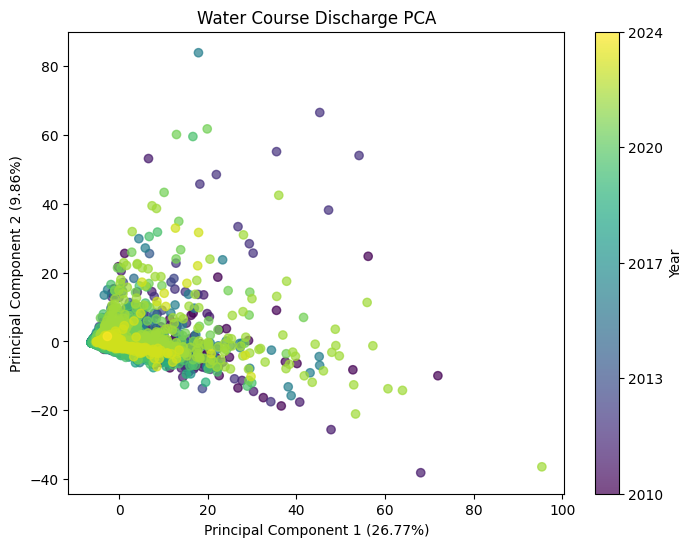

Explained Variance Ratio: [0.26772685 0.09862906]
      principal component 1  principal component 2
0                 -3.270982              -1.649389
1                 -2.340138              -1.538396
2                 -3.244419              -1.173932
3                 -4.608783              -0.673104
4                 -5.110213              -0.524071
...                     ...                    ...
5109               4.857152               8.129639
5110               1.180129               4.569160
5111              -0.833903               2.988757
5112              -1.975836               1.987110
5113              -2.649986               1.468455

[5114 rows x 2 columns]


In [8]:
# Example usage:
WaterCourse_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanWaterCourseDischarge.csv'
combined_data = process_and_combine_data(WaterCourse_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)


time_values = combined_data['Time_ordinal'].values
year_values = pd.to_datetime(combined_data['Time']).dt.year  # Replace 'Time' with the appropriate column name
# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
explained_variance_ratios = pca.explained_variance_ratio_
pc1_variance_ratio = explained_variance_ratios[0] * 100
pc2_variance_ratio = explained_variance_ratios[1] * 100



# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=year_values, cmap='viridis', alpha=0.7)


colorbar = plt.colorbar(scatter, label='Year')
tick_labels = [str(int(year)) for year in np.linspace(year_values.min(), year_values.max(), 5)]
colorbar.set_ticks(np.linspace(year_values.min(), year_values.max(), 5))
colorbar.set_ticklabels(tick_labels)

plt.title('Water Course Discharge PCA')
plt.xlabel(f'Principal Component 1 ({pc1_variance_ratio:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance_ratio:.2f}%)')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(principalDf)

# SARIMA

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


WATERTEMP = pd.read_csv(Water_temp_file_path, parse_dates=['Time'], index_col='Time')
TURBIDITY = pd.read_csv(Turbidity_temp_file_path, parse_dates=['Time'], index_col='Time')
AIRTEMP = pd.read_csv(DryAir_temp_file_path, parse_dates=['Time'], index_col='Time')
RAINFALL = pd.read_csv(Rainfall_temp_file_path, parse_dates=['Time'], index_col='Time')
WATERCOURSE = pd.read_csv(WaterCourse_temp_file_path, parse_dates=['Time'], index_col='Time')
ELECTRICALCOND = pd.read_csv(EC_temp_file_path, parse_dates=['Time'], index_col='Time')


ZONEDATA = zone_data_1A_top_sorted


from statsmodels.tsa.stattools import adfuller

# Function to test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Assuming 'principal component 1' as the target series
test_stationarity(ZONEDATA['principal component 1'])


In [45]:
# Combine exogenous data into a single DataFrame, aligning by date
exog_data = pd.concat([WATERTEMP, TURBIDITY, AIRTEMP, RAINFALL, WATERCOURSE, ELECTRICALCOND], axis=1)

# Assuming 'finalDf' and 'principal component 1' are already defined and correct
# Make sure 'finalDf' is also indexed by date

# Aligning exogenous data with finalDf
exog_data.index = pd.to_datetime(exog_data.index)

exog_data = exog_data.fillna(method='bfill').interpolate(method='time')
print(exog_data.shape)



exog_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace all inf/-inf with NaN
exog_data = exog_data.dropna(axis=1)
exog_data = exog_data.dropna(axis=0)
print(exog_data.shape)
print(exog_data)


/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_14732/141126251.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_data = exog_data.fillna(method='bfill').interpolate(method='time')


(14001, 2930)
(14001, 2930)
                           2122518  2122711  2122713  2122725   215208  \
Time                                                                     
2010-01-01 00:00:00+10:00    21.14    22.95    20.19    22.99    17.86   
2010-01-01 00:30:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-01 02:00:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-02 00:00:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-02 00:30:00+10:00    21.14    22.54    20.19    19.27    17.86   
...                            ...      ...      ...      ...      ...   
2023-12-30 00:00:00+10:00     0.00    20.64    19.25    18.84 -9999.00   
2023-12-30 00:30:00+10:00     0.00    20.67    19.25    18.84 -9999.00   
2023-12-31 00:00:00+10:00     0.00    20.67    19.25    18.84 -9999.00   
2023-12-31 00:30:00+10:00     0.00    20.53    19.25    18.84 -9999.00   
2024-01-01 00:00:00+10:00     0.00    20.53    19.25    18.84 -9999.00   

         

In [58]:
# Create final DataFrame
finalDf = ZONEDATA.copy()
# Assuming 'Create_date' is the column to align by
finalDf['Create_date'] = pd.to_datetime(finalDf['Create_date'])
finalDf.set_index('Create_date', inplace=True)

# Convert index to datetime if it isn't already
exog_data.index = pd.to_datetime(exog_data.index)
# Remove time zone information from exog_data
exog_data.index = exog_data.index.tz_localize(None)

# Resample to daily frequency using the mean
exog_data_daily = exog_data.resample('D').mean()

# Assuming 'Create_date' is the column to align by and it is already the index
finalDf.index = pd.to_datetime(finalDf.index)

# Ensure it's tz-naive
finalDf.index = finalDf.index.tz_localize(None)

# Join the datasets
alignedDf = finalDf.join(exog_data_daily, how='inner')  # 'inner' to keep only matched indices



# Check for any remaining NaN values and drop if necessary
alignedDf.dropna(axis=1, inplace=True)

# Now you can proceed with your analysis

print(alignedDf)

columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal']

alignedDf = alignedDf.drop(columns=columns_to_exclude, errors='ignore')  # errors='ignore' to handle any missing columns gracefully


              Status Application Creation Date Approved / Refused Date  \
2010-01-02  Recorded                2010-01-02              10/02/2010   
2010-01-09   Refused                2010-01-09              02/09/2010   
2010-01-09   Refused                2010-01-09              02/09/2010   
2010-01-09   Refused                2010-01-09              01/09/2010   
2010-01-09   Refused                2010-01-09              01/09/2010   
...              ...                       ...                     ...   
2023-12-22  Recorded                2023-12-22              10/01/2024   
2023-12-22  Recorded                2023-12-22              10/01/2024   
2023-12-22  Recorded                2023-12-22              22/12/2023   
2023-12-22   Refused                2023-12-22              26/04/2024   
2023-12-22  Recorded                2023-12-22              10/01/2024   

           Recorded / Rejected Date Water Share ID Water System Source  \
2010-01-02               12/03/2010  

In [60]:




# Assume you're using 'Price Per ML ($)' as the dependent variable
model = sm.tsa.statespace.SARIMAX(
    alignedDf['Price Per ML ($)'],
    exog=alignedDf.drop(columns=['Price Per ML ($)']),  # Exclude target variable from exog
    order=(0, 0, 0),
    seasonal_order=(1, 0, 1, 12)
)
results = model.fit()

# Forecasting, plotting, etc., as needed.


# Get forecast of next 12 periods with confidence intervals
forecast = results.get_forecast(steps=12, exog=finalDf.drop(columns=['Price Per ML ($)'])[-12:])  # Include exog for forecast periods
forecast_ci = forecast.conf_int()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(finalDf.index, finalDf['Price Per ML ($)'], label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='r', label='Forecast')
plt.fill_between(forecast.predicted_mean.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.9)

plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Price Per ML ($)')
plt.legend()
plt.show()



/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
print(combined_data)



                          Time  2122711  215002  215007  215014   215208  \
0    2010-01-01 00:00:00+10:00    0.458   0.000   0.064   0.001    0.000   
1    2010-01-02 00:00:00+10:00    0.394   0.002   0.089   0.000    0.000   
2    2010-01-03 00:00:00+10:00    0.466   0.001   0.157   0.000    0.034   
3    2010-01-04 00:00:00+10:00    0.665   0.001   0.114   0.000    0.050   
4    2010-01-05 00:00:00+10:00    0.624   0.032   0.093   0.004    0.041   
...                        ...      ...     ...     ...     ...      ...   
5109 2023-12-28 00:00:00+10:00   40.762  94.502   6.055   0.029  207.445   
5110 2023-12-29 00:00:00+10:00   10.628  51.224   3.747   0.026  101.668   
5111 2023-12-30 00:00:00+10:00    4.121  29.822   2.769   0.020   55.115   
5112 2023-12-31 00:00:00+10:00    2.221  20.554   2.359   0.015   35.996   
5113 2024-01-01 00:00:00+10:00    1.551  16.716   1.935   0.015   28.126   

      215239  217006  218001  218005  ...  410851  411003  412005  412045  \
0      0.0

In [ ]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error



In [ ]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt


def build_sarimax_model(data, order, seasonal_order):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit()
    return fitted_model

def forecast_and_simulate(model, steps=1000):
    # Get the forecast result
    forecast_result = model.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    # Convert MultiIndex DataFrame to standard column format
    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']
    return forecast_mean, conf_intervals

# Assuming the 'Price Per ML ($)' column contains the data of interest
series_data = combined_data.set_index('Create_date_ordinal')['Price Per ML ($)']

# Split data into training and testing sets using train_test_split
# Note: shuffle=False is crucial for time series data to maintain the temporal order
train_data, test_data = train_test_split(series_data, test_size=0.3, shuffle=False)

# Build ARMA model on training data
sarimax_model = build_sarimax_model(train_data, order=(10, 1, 10), seasonal_order=(1, 0, 1, 12))

# Simulate future prices on test data
forecast_series, conf_df = forecast_and_simulate(sarimax_model, steps=len(test_data))

# Visualization
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_data.index, train_data, label="Training Data", color='blue')

# Plot moving average line using fitted values
plt.plot(train_data.index, sarimax_model.fittedvalues, label="Moving Average", color='purple', linestyle=':')


# Plot testing data
plt.plot(test_data.index, test_data, label="Testing Data", color='red')

# Plot forecasted data
plt.plot(test_data.index, forecast_series, label="Forecasted Prices", linestyle='--', color='green')

# Fill between for confidence intervals
plt.fill_between(test_data.index, conf_df['lower'], conf_df['upper'], alpha=0.3, color='lightgreen')

# Add gridlines for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and legend
plt.xlabel("Date (Ordinal)")
plt.ylabel("Price Per ML ($)")
plt.legend()

# Title and show plot
plt.title("SARIMAX Model Forecast for Price Per ML")
plt.tight_layout()
plt.show()

# Validate model parameters and convergence
if not sarimax_model.mle_retvals['converged']:
    print("Warning: Model did not converge. Check model parameters and data.")
else:
    print("Model converged successfully.")


# Validate forecast intervals
if conf_df['lower'].isnull().any() or conf_df['upper'].isnull().any():
    print("Warning: Confidence intervals contain null values. Check forecast outputs.")
else:
    print("Confidence intervals generated successfully.")
# Display model fit summary
print("Model Summary:")
print(sarimax_model.summary())

# Calculate and display error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate errors on the test data
mse = mean_squared_error(test_data, forecast_series)
mae = mean_absolute_error(test_data, forecast_series)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

from sklearn.metrics import r2_score
r_squared = r2_score(test_data, forecast_series)
print("R-squared:", r_squared)


KeyError: "None of ['Create_date_ordinal'] are in the columns"